# TP 1: recommandations par filtres collaboratifs utilisateur-utilisateur et item-item 

In [1]:
### Si données locales
u.user <- read.csv(file='u.user.csv', sep='|', header=T)
u.item <- read.csv(file='u.item.csv', sep='|', header=T)
u.data <- read.csv(file='u.data.csv', sep='|', header=T)


library(Matrix)
m.sparse <- sparseMatrix(u.data[,1],u.data[,2],x=u.data[,3])
rownames(m.sparse) <- paste(1:nrow(m.sparse), sep='')
colnames(m.sparse) <- u.item$movie.title


Quelque fonctions utiles:

In [2]:
max.nindex <- function(m, n=5) {
  i <- order(m, decreasing=TRUE)
  return(i[1:n])
}
min.nindex <- function(m, n=5) {
  i <- order(m)
  return(i[1:n])
}

# Q1 
*Quelle est la moyenne des votes par profession ("job") et par âge?*

On va dans un premier temps effectuer une fusion entre la table des utilisateurs et les votes, pour obtenir facilement le job et ages correspondant à chaque vote

In [3]:
user_data <- merge(u.data, u.user, by.x = 'user.id', by.y = 'id')

on va ensuite faire la moyenne de tout les votes, en groupant par jobs

In [4]:
# moyenne par profession
head(aggregate(user_data$rating, by=list(user_data$job), FUN=mean))

Group.1,x
<fct>,<dbl>
administrator,3.635646
artist,3.653380
doctor,3.688889
educator,3.670621
engineer,3.541407
entertainment,3.441050


On effectue la même chose pour l'age

In [5]:
# moyenne par age
head(aggregate(user_data$rating, by=list(user_data$age), FUN=mean))

Group.1,x
<int>,<dbl>
7,3.767442
10,3.387097
11,2.925926
13,3.470825
14,3.375000
15,3.264484


# Q2
*Quels sont les 10 films les plus similaires à "Star Trek V: The Final Frontier (1989)" selon respectivement la mesure du cosinus et de la corrélation avec la matrice de votes.*


### Avec le cosinus

Dans un premier temps, on selectionne le vecteur de vote correspondant a star trek

In [6]:
start_trek_vect <- m.sparse[,'Star Trek V: The Final Frontier (1989)']

Ensuite, on calcul le cosinus de ce vecteur et de tout les autres vecteurs des autres films

In [7]:
## Cosinus entre un vecteur v et chaque colonne dela matrice m
cosinus.vm <- function(v,m) {
    n <- sqrt(colSums(m^2)); (v %*% m)/(n * sqrt(sum(v^2))) 
}

mat_cos <- cosinus.vm(start_trek_vect, m.sparse)

Enfin, on selectionne seulement les 11 premiers films qui ont le plus grand cosinus (Star Trek V: The Final Frontier (1989) et les 10 autres films les plus similaires)

In [8]:
top_10_index_cos <- max.nindex(mat_cos, n = 11)
top_10_cos <- u.item$movie.title[top_10_index_cos]
show(top_10_cos)

 [1] Star Trek V: The Final Frontier (1989)       
 [2] Star Trek: The Motion Picture (1979)         
 [3] Star Trek VI: The Undiscovered Country (1991)
 [4] Star Trek III: The Search for Spock (1984)   
 [5] Star Trek IV: The Voyage Home (1986)         
 [6] Star Trek: The Wrath of Khan (1982)          
 [7] Stargate (1994)                              
 [8] Star Trek: Generations (1994)                
 [9] Die Hard 2 (1990)                            
[10] Escape from New York (1981)                  
[11] Conan the Barbarian (1981)                   
1664 Levels: 'Til There Was You (1997) 1-900 (1994) ... Zeus and Roxanne (1997)


### Avec la corrélation de Pearson

Pour la corrélation, une fonction native existe dans les packages par défaut de R.

On utilise cette fonction sur chaque item de la matrice m.sparse

In [9]:
## corrélation de Pearson entre un vecteur v et chaque colonne dela matrice m

cor.vm <- function(v, m) {
    # ici, le parametre 2 indique que nous effectuons la corrélation
    # sur les colones et non sur les lignes
    apply(m, 2, cor, y=v, use="pairwise.complete.obs")
}
mat_cor = cor.vm(start_trek_vect, m.sparse)

On applique ensuite le même raisonnement que pour la mesure du cosinus

In [10]:
top_10_index_cor <- max.nindex(mat_cor, n = 11)
top_10_cor <- u.item$movie.title[top_10_index_cor]
show(top_10_cor)

 [1] Star Trek V: The Final Frontier (1989)       
 [2] Star Trek: The Motion Picture (1979)         
 [3] Star Trek VI: The Undiscovered Country (1991)
 [4] Star Trek III: The Search for Spock (1984)   
 [5] Star Trek IV: The Voyage Home (1986)         
 [6] Star Trek: The Wrath of Khan (1982)          
 [7] Stargate (1994)                              
 [8] Star Trek: Generations (1994)                
 [9] Die Hard 2 (1990)                            
[10] Escape from New York (1981)                  
[11] Conan the Barbarian (1981)                   
1664 Levels: 'Til There Was You (1997) 1-900 (1994) ... Zeus and Roxanne (1997)


## Q3 
*Utilisez une approche item-item pour calculer le vote au film "Star Trek V: The Final Frontier (1989)" des utilisateurs qui n'ont pas de vote pour celui-ci. Prenez les 20 voisins les plus rapprochés selon la distance euclidienne et utilisez les cosinus comme poids. Si aucun vote commun existe, alors la valeur prédite est fixée à NA.*

Dans un premier temps, il faut calculer les distances de chaque filme par rapport à star trek

On va utiliser la distance.450 définie dans l'aide fournie, qui conserve les valeures manquantes à 0 pour le calcul de la distance

In [11]:
distance.450 <- sqrt(colSums((m.sparse[,450] - m.sparse)^2)) # valeurs manquantes à 0

On va ensuite determiner les 20 voisins les plus proches, ce sont ceux dont la distance est minimal (sans prendre en compte star strek)

In [12]:
voisins_star_trek = min.nindex(distance.450, 21)[2:21]

In [13]:
u.item$movie.title[voisins_star_trek]

[1] Robocop 3 (1993)                                
 [2] Mr. Magoo (1997)                                
 [3] Vampire in Brooklyn (1995)                      
 [4] Jerky Boys, The (1994)                          
 [5] Across the Sea of Time (1995)                   
 [6] Blood For Dracula (Andy Warhol's Dracula) (1974)
 [7] Fair Game (1995)                                
 [8] Phat Beach (1996)                               
 [9] S.F.W. (1994)                                   
[10] Window to Paris (1994)                          
[11] Farmer & Chase (1995)                           
[12] Fire on the Mountain (1996)                     
[13] Open Season (1996)                              
[14] Tough and Deadly (1995)                         
[15] Daniel Defoe's Robinson Crusoe (1996)           
[16] Blood Beach (1981)                              
[17] Paris Was a Woman (1995)                        
[18] Bad Girls (1994)                                
[19] Mad Dog Time (1996)                             
[20] Shooter, The (1995)                             
1664 Levels: 'Til There Was You (1997) 1-900 (1994) ... Zeus and Roxanne (1997)

On applique ensuite la pondération par cosinus sur ces voisins pour déterminer les notes manquantes

In [14]:
poids_voisins <- cosinus.vm(start_trek_vect, m.sparse[, voisins_star_trek])
head(as.matrix(poids_voisins))

Robocop 3 (1993),Mr. Magoo (1997),Vampire in Brooklyn (1995),"Jerky Boys, The (1994)",Across the Sea of Time (1995),Blood For Dracula (Andy Warhol's Dracula) (1974),Fair Game (1995),Phat Beach (1996),S.F.W. (1994),Window to Paris (1994),Farmer & Chase (1995),Fire on the Mountain (1996),Open Season (1996),Tough and Deadly (1995),Daniel Defoe's Robinson Crusoe (1996),Blood Beach (1981),Paris Was a Woman (1995),Bad Girls (1994),Mad Dog Time (1996),"Shooter, The (1995)"
0.3180997,0.2790087,0.2580293,0.2318994,0.207867,0.2027901,0.2342691,0.1891935,0.1903723,0.1891935,0.1891935,0.1891935,0.1835447,0.1855195,0.1692198,0.1817712,0.1418951,0.1577983,0.1418951,0.1576916


On cherche maintenant a avoir la liste des utilisateurs qui ont voté pour au moins 1 des 20 films les plus proches, et qui n'ont pas voté pour star trek

In [15]:
# on selectionne les utilisateurs qui n'ont pas voté pour star trek
user_index_non_vote_start_treck <- which(start_trek_vect == 0)
# on croise avec les utilisateurs qui ont voté pour au moins 1 des films parmis les 20 les plus proches
user_to_process <- intersect(which(rowSums(m.sparse[, voisins_star_trek]) !=0), user_index_non_vote_start_treck)
show(user_to_process)

 [1]  21  37  82 109 110 181 345 358 404 425 537 577 609 615 617 634 642 671 729
[20] 749 756 805 811 813 833 854 863 893 932


On applique maintenant la formule vue en cours pour calculer les notes de chaque utilisateur conserné

- On retire les valeures 0 pour calculer les moyennes  

In [16]:
start_trek_vect[start_trek_vect == 0] <- NA
m_sparse_voisin <- m.sparse[, voisins_star_trek]
m_sparse_voisin[m_sparse_voisin == 0] <- NA

mean_note_voisins <- apply(m_sparse_voisin, 2, mean, na.rm = TRUE)
mean_note_star_treck <- mean(start_trek_vect, na.rm = TRUE)
head(as.matrix(mean_note_voisins), 100)
print(cat("moyenne pour star treck: ", mean_note_star_treck))

Robocop 3 (1993),1.727273
Mr. Magoo (1997),1.916667
Vampire in Brooklyn (1995),1.833333
"Jerky Boys, The (1994)",2.666667
Across the Sea of Time (1995),2.750000
Blood For Dracula (Andy Warhol's Dracula) (1974),2.400000
Fair Game (1995),2.181818
Phat Beach (1996),1.600000
S.F.W. (1994),3.000000
Window to Paris (1994),4.000000
Farmer & Chase (1995),4.000000


moyenne pour star treck:  2.396825NULL


- On créer une nouvelle matrice centrée sur la moyenne des films voisins (correspondant à la somme des termes $v_{i,j}-\bar{v_{i}}$). On fait cela pour ne pas prendre en compte les valeurs manquantes, misent à 0 dans m.sparse, et qui doivent rester à 0 pour ne pas compter dans le somme

In [17]:
m.sparse.to_center <- m.sparse[, voisins_star_trek]
m.sparse.to_center[m.sparse.to_center == 0] <- NA

m.sparse.centered <- m.sparse.to_center[user_to_process,] - mean_note_voisins
m.sparse.centered[is.na(m.sparse.centered)] <- 0
head(as.matrix(m.sparse[user_to_process, voisins_star_trek]))
head(as.matrix(m.sparse.centered))

,Robocop 3 (1993),Mr. Magoo (1997),Vampire in Brooklyn (1995),"Jerky Boys, The (1994)",Across the Sea of Time (1995),Blood For Dracula (Andy Warhol's Dracula) (1974),Fair Game (1995),Phat Beach (1996),S.F.W. (1994),Window to Paris (1994),Farmer & Chase (1995),Fire on the Mountain (1996),Open Season (1996),Tough and Deadly (1995),Daniel Defoe's Robinson Crusoe (1996),Blood Beach (1981),Paris Was a Woman (1995),Bad Girls (1994),Mad Dog Time (1996),"Shooter, The (1995)"
21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
82,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
109,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
110,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,2,0,0
181,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0


,Robocop 3 (1993),Mr. Magoo (1997),Vampire in Brooklyn (1995),"Jerky Boys, The (1994)",Across the Sea of Time (1995),Blood For Dracula (Andy Warhol's Dracula) (1974),Fair Game (1995),Phat Beach (1996),S.F.W. (1994),Window to Paris (1994),Farmer & Chase (1995),Fire on the Mountain (1996),Open Season (1996),Tough and Deadly (1995),Daniel Defoe's Robinson Crusoe (1996),Blood Beach (1981),Paris Was a Woman (1995),Bad Girls (1994),Mad Dog Time (1996),"Shooter, The (1995)"
21,0,0,0.00000000,0,0,0,0,0.0,0,0,0,0,0,0,0,-1.166667,0,0.0000000,0,0.0
37,0,0,0.00000000,0,0,0,0,0.0,0,0,0,0,0,0,0,0.000000,0,0.0000000,0,0.5
82,0,0,0.00000000,0,0,0,0,-1.4,0,0,0,0,0,0,0,0.000000,0,0.0000000,0,0.0
109,0,0,0.08333333,0,0,0,0,0.0,0,0,0,0,0,0,0,0.000000,0,0.0000000,0,0.0
110,0,0,0.00000000,0,0,0,0,0.0,0,0,0,0,0,0,0,0.000000,0,0.1666667,0,0.0
181,0,0,0.00000000,0,0,0,0,-2.0,0,0,0,0,-2,0,0,0.000000,0,0.0000000,0,0.0


- On applique la formule

In [18]:
notes_prediction <- mean_note_star_treck + (m.sparse.centered %*% t(poids_voisins)) / sum(poids_voisins)
head(as.matrix(notes_prediction))

21,2.343788
37,2.416545
82,2.330582
109,2.402203
110,2.403403
181,2.210384


On peut voir que la différence est très minime entre les notes. Cela est due au fait que $sum(w_{a,i})$ est calculée en conservant les valeures manquante dans le compte.

Une autre solution plus intelligente serais de mettre a zero le coefficient $w_{a,i}$, là ou le vote $i,j$ n'est pas présent. Pour cela, nous allons conserver la solution précedente (via les moyenne) qui gère bien les valeures manquante au dénominateur, et nous concentrer uniquement sur le recalcul du dénomiateur. 

Pour cela, nous allons pondérer la somme via une matrice des votes binaire (0 si le vote n'a pas eu lieu, et 1 si le vote a eu lieu). On ne prend en compte que les 20 films les plus proches et les utilisateurs qui ont voté sur au moins 1 de ces films:

In [42]:
m.sparse.binaire <- m.sparse[user_to_process, voisins_star_trek]
m.sparse.binaire[m.sparse.binaire != 0] <- 1
head(as.matrix(m.sparse.binaire))

,Robocop 3 (1993),Mr. Magoo (1997),Vampire in Brooklyn (1995),"Jerky Boys, The (1994)",Across the Sea of Time (1995),Blood For Dracula (Andy Warhol's Dracula) (1974),Fair Game (1995),Phat Beach (1996),S.F.W. (1994),Window to Paris (1994),Farmer & Chase (1995),Fire on the Mountain (1996),Open Season (1996),Tough and Deadly (1995),Daniel Defoe's Robinson Crusoe (1996),Blood Beach (1981),Paris Was a Woman (1995),Bad Girls (1994),Mad Dog Time (1996),"Shooter, The (1995)"
7,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0
13,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0
127,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
130,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
145,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
267,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Une fois cette matrice créée, nous allons effectuer le produit matricielle de la matrice avec des poids calculée auparavant, et effectuer la somme sur les films pour obtenir $w_{a,i}$ de chaque utilisateur n'ayant pas voté.

In [20]:
poids_voisins.pondere <- m.sparse.binaire %*% t(poids_voisins)
show(sum(poids_voisins))
head(as.matrix(poids_voisins.pondere))

[1] 3.998445


21,0.1817712
37,0.1576916
82,0.1891935
109,0.2580293
110,0.3920674
181,0.3727382


Nous n'avons plus besoin de normaliser la matrice des votes car lorsque $v_{i,j}$ sera manquante, la valeur $w_{a,i}$ sera nul et la valeur manquante ne sera pas prise en compte

In [21]:
notes_prediction <- mean_note_star_treck + (m.sparse.centered %*% t(poids_voisins)) / poids_voisins.pondere
head(as.matrix(notes_prediction), 100)

21,1.2301587
37,2.8968254
82,0.9968254
109,2.4801587
110,2.4639050
181,0.3968254
345,1.7301587
358,2.8968254
404,2.5634921
425,1.7301587
537,0.7301587


### Q4
*Calculez l'erreur quadratique moyenne des prédiction de l'approche item-item à la question précédente en la comparant aux valeurs observées.*

Pour calculer l'erreur quadratique, nous allons devoir trouver les utilisateurs qui ont voté pour le films, et qui ont eux aussi voté pour les 20 films les plus proches

In [22]:
# on selectionne les utilisateurs qui n'ont pas voté pour star trek
user_index_start_treck <- which(start_trek_vect != 0)
# on croise avec les utilisateurs qui ont voté pour au moins 1 des films parmis les 20 les plus proches
user_to_process <- intersect(which(rowSums(m.sparse[, voisins_star_trek]) !=0), user_index_start_treck)
show(user_to_process)

 [1]   7  13 127 130 145 267 276 279 303 394 399 405 417 497 532 600 650 774 807


On reconstruit notre matrice de vote centrée sur la moyenne des notes des films voisins

In [23]:
m.sparse.to_center <- m.sparse[, voisins_star_trek]
m.sparse.to_center[m.sparse.to_center == 0] <- NA

m.sparse.centered <- m.sparse.to_center[user_to_process,] - mean_note_voisins
m.sparse.centered[is.na(m.sparse.centered)] <- 0

On va ensuite prédire leurs notes:

In [24]:
# on re calcul la matrice des votes binaires
m.sparse.binaire <- m.sparse[user_to_process, voisins_star_trek]
m.sparse.binaire[m.sparse.binaire != 0] <- 1

# On calcul les poids pondérés par utilisateurs
poids_voisins.pondere <- m.sparse.binaire %*% t(poids_voisins)

# on prédit leurs notes
notes_prediction <- mean_note_star_treck + (m.sparse.centered %*% t(poids_voisins)) / poids_voisins.pondere
head(as.matrix(notes_prediction))

7,2.9193662
13,2.2732315
127,5.4801587
130,1.6522810
145,0.7301587
267,1.7301587


Nous allons maintenant calculer l'erreur quadratique vis a vis des notes réelles

In [25]:
erreur_quadra <- sqrt(sum((notes_prediction - m.sparse[user_to_process, 'Star Trek V: The Final Frontier (1989)'])**2)/length(notes_prediction))
print(cat("erreure quadratique: ", erreur_quadra))
head(as.matrix(notes_prediction), 100)
head(as.matrix(m.sparse[user_to_process, 'Star Trek V: The Final Frontier (1989)']), 100)

erreure quadratique:  1.089232NULL


7,2.9193662
13,2.2732315
127,5.4801587
130,1.6522810
145,0.7301587
267,1.7301587
276,1.4049780
279,3.5693350
303,1.7912787
394,4.2150072
399,0.2925599


7,4
13,3
127,5
130,2
145,3
267,2
276,1
279,4
303,3
394,3
399,2


### Q5
*Utilisez une approche par agglomération (clustering) pour prédire les votes et calculez l'erreur quadratique moyenne.*

Tout d'abord on construit une matrice qui ne contient pas de valeur manquantes à 0

Pour effectuer l'algorithme k-mean, il est préférable de remplacer les valeures manquantes par les moyennes par films ou par utilisateurs. Ici, comme nous voulons grouper les utilisateurs, nous allons corriger la matrice avec les moyennes respectives des films.

In [26]:
library(stats)

# on normalise avec les moyennes par utilisateurs
m.sparse.for_kmean_by_user <- t(apply(m.sparse.to_normalisee, 1, normalization_by_mean))
# on normalise avec les moyennes par films
m.sparse.for_kmean_by_film <- apply(m.sparse.to_normalisee, 2, normalization_by_mean)

Ensuite, on utilise la fonction native du module stats de R pour clusteriser les utilisateurs, et définir entre 5 et 20 utilisateurs "moyens"

In [27]:
library(stats)
k_mean_obj <- kmeans(m.sparse.for_kmean_by_film, 5)
centers5 <- as.matrix(k_mean_obj$centers)
clusters5 <- as.matrix(k_mean_obj$cluster)
head(centers5)

Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Twelve Monkeys (1995),Babe (1995),Dead Man Walking (1995),Richard III (1995),⋯,Mirage (1995),Mamma Roma (1962),"Sunchaser, The (1996)","War at Home, The (1996)",Sweet Nothing (1995),Mat' i syn (1997),B. Monkey (1998),Sliding Doors (1998),You So Crazy (1994),Scream of Stone (Schrei aus Stein) (1991)
3.860164,3.195730,3.029735,3.536497,3.300773,3.586921,3.783939,3.980594,3.940222,3.840606,⋯,3,4,3,2,3,1,3,2,3,3
3.878319,1.000000,3.033333,4.000000,4.000000,3.576923,3.798469,4.000000,3.896321,3.831461,⋯,3,4,3,2,3,1,3,2,3,3
4.163274,3.372964,3.070556,3.602671,3.398643,3.576923,3.792581,4.071956,3.603595,3.799625,⋯,3,4,3,2,3,1,3,2,3,3
4.227417,3.377503,3.212579,3.881195,3.335674,3.555152,4.316663,4.261911,4.315454,3.866441,⋯,3,4,3,2,3,1,3,2,3,3
3.264227,2.904639,2.857436,3.325506,3.103399,3.486391,3.544192,3.797541,3.619501,3.762662,⋯,3,4,3,2,3,1,3,2,3,3


In [28]:
k_mean_obj <- kmeans(m.sparse.for_kmean_by_film, 10)
centers10 <- as.matrix(k_mean_obj$centers)
clusters10 <- as.matrix(k_mean_obj$cluster)
head(centers10, 10)

Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Twelve Monkeys (1995),Babe (1995),Dead Man Walking (1995),Richard III (1995),⋯,Mirage (1995),Mamma Roma (1962),"Sunchaser, The (1996)","War at Home, The (1996)",Sweet Nothing (1995),Mat' i syn (1997),B. Monkey (1998),Sliding Doors (1998),You So Crazy (1994),Scream of Stone (Schrei aus Stein) (1991)
3.449740,3.191338,3.008696,3.505617,3.247725,3.595318,3.734084,3.910363,3.721754,3.868100,⋯,3,4,3,2,3,1,3,2,3,3
3.824050,3.197441,2.995588,3.555643,3.297196,3.588462,3.721399,3.987456,3.966683,3.841970,⋯,3,4,3,2,3,1,3,2,3,3
3.245739,2.861747,2.764198,3.327840,3.038760,3.497151,3.673847,3.886352,3.905364,3.850187,⋯,3,4,3,2,3,1,3,2,3,3
3.000000,3.000000,3.033333,5.000000,1.000000,3.576923,2.000000,4.000000,3.000000,3.831461,⋯,3,4,3,2,3,1,3,2,3,3
3.938771,3.202326,3.057188,3.526270,3.319023,3.578928,3.814610,3.996137,3.845060,3.823633,⋯,3,4,3,2,3,1,3,2,3,3
4.210454,3.333969,3.074167,4.040072,3.304070,3.583654,4.294770,4.298059,4.311120,3.923596,⋯,3,4,3,2,3,1,3,2,3,3
3.000000,3.206107,2.000000,3.550239,3.302326,1.000000,4.000000,3.995434,4.000000,2.000000,⋯,3,4,3,2,3,1,3,2,3,3
2.719580,2.301527,2.891667,2.818780,2.938953,3.432692,3.250000,2.999429,3.586120,3.436798,⋯,3,4,3,2,3,1,3,2,3,3
3.878319,1.000000,3.033333,4.000000,4.000000,3.576923,3.798469,4.000000,3.896321,3.831461,⋯,3,4,3,2,3,1,3,2,3,3
4.360348,3.540378,3.238596,3.562411,3.456140,3.576923,4.006400,4.085396,3.759080,3.811157,⋯,3,4,3,2,3,1,3,2,3,3


In [29]:
k_mean_obj <- kmeans(m.sparse.for_kmean_by_film, 20)
centers20 <- as.matrix(k_mean_obj$centers)
clusters20 <- as.matrix(k_mean_obj$cluster)
head(centers20, 20)

Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Twelve Monkeys (1995),Babe (1995),Dead Man Walking (1995),Richard III (1995),⋯,Mirage (1995),Mamma Roma (1962),"Sunchaser, The (1996)","War at Home, The (1996)",Sweet Nothing (1995),Mat' i syn (1997),B. Monkey (1998),Sliding Doors (1998),You So Crazy (1994),Scream of Stone (Schrei aus Stein) (1991)
4.000000,3.801527,3.025000,3.525120,3.226744,3.576923,3.649235,4.248858,3.922241,3.831461,⋯,3,4,3,2,3,1,3,2,3,3
4.195182,3.294317,3.025926,3.627858,3.302326,3.623932,3.999150,4.330289,4.041992,4.369538,⋯,3,4,3,2,3,1,3,2,3,3
5.000000,4.500000,4.016667,3.500000,3.476744,3.576923,4.750000,4.497717,4.448161,3.623596,⋯,3,4,3,2,3,1,3,2,3,3
3.878319,1.000000,3.033333,4.000000,4.000000,3.576923,3.798469,4.000000,3.896321,3.831461,⋯,3,4,3,2,3,1,3,2,3,3
3.828097,3.205203,3.021495,3.537368,3.304493,3.588936,3.724869,3.973385,3.965519,3.834121,⋯,3,4,3,2,3,1,3,2,3,3
3.878319,2.000000,5.000000,2.000000,4.000000,3.576923,5.000000,3.995434,5.000000,3.831461,⋯,3,4,3,2,3,1,3,2,3,3
3.000000,4.000000,3.033333,4.000000,3.302326,3.576923,5.000000,3.995434,3.896321,4.000000,⋯,3,4,3,2,3,1,3,2,3,3
3.878319,3.137405,3.022222,2.850080,2.100775,3.576923,3.266156,3.665145,3.930881,3.831461,⋯,3,4,3,2,3,1,3,2,3,3
4.000000,3.603053,3.016667,2.275120,3.500000,3.576923,4.000000,3.995434,1.500000,3.831461,⋯,3,4,3,2,3,1,3,2,3,3
3.970542,3.202788,3.049879,3.510349,3.319599,3.576923,3.835200,3.988733,3.814539,3.832112,⋯,3,4,3,2,3,1,3,2,3,3


On va maintenant essayer de prédire la note de Star treck en déterminant dans quel cluster l'utilisateur se trouve et quelle est la note attribuée par le cluster

In [30]:
get_prediction <- function(clusters, centers) {
  
  clusters <- as.data.frame(clusters)
  colnames(clusters) <- "clusters"
  clusters$user_name = rownames(clusters)
  
  centers <- as.data.frame(centers)
  centers$cluster_num <- rownames(centers)
  
  # on fusionne les tables clusters et centers pour obtenir les prédictions pour chaque utilisateur en fonction de son cluster d'appartenance
  prediction <- merge.data.frame(clusters, centers, by.x = "clusters", by.y = "cluster_num")
  
  # on retrie les prédictions par utilisateur pour pouvoir selectionner les utilisateurs par index
  rownames(prediction) <- prediction$user_name
  return(prediction[order(as.numeric(prediction$user_name)),])
}

prediction5 <- get_prediction(clusters5, centers5)
head(prediction5)
# on selectionne seulement les notes des utilisateurs ayant voté star treck
user_star_treck_prediction <- prediction5[user_index_start_treck,]

head(user_star_treck_prediction["Star Trek V: The Final Frontier (1989)"])
head(m.sparse[user_index_start_treck, 'Star Trek V: The Final Frontier (1989)'])

clusters,user_name,Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Twelve Monkeys (1995),Babe (1995),⋯,Mirage (1995),Mamma Roma (1962),"Sunchaser, The (1996)","War at Home, The (1996)",Sweet Nothing (1995),Mat' i syn (1997),B. Monkey (1998),Sliding Doors (1998).1,You So Crazy (1994),Scream of Stone (Schrei aus Stein) (1991)
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,3.860164,3.195730,3.029735,3.536497,3.300773,3.586921,3.783939,3.980594,⋯,3,4,3,2,3,1,3,2,3,3
1,2,3.860164,3.195730,3.029735,3.536497,3.300773,3.586921,3.783939,3.980594,⋯,3,4,3,2,3,1,3,2,3,3
1,3,3.860164,3.195730,3.029735,3.536497,3.300773,3.586921,3.783939,3.980594,⋯,3,4,3,2,3,1,3,2,3,3
1,4,3.860164,3.195730,3.029735,3.536497,3.300773,3.586921,3.783939,3.980594,⋯,3,4,3,2,3,1,3,2,3,3
5,5,3.264227,2.904639,2.857436,3.325506,3.103399,3.486391,3.544192,3.797541,⋯,3,4,3,2,3,1,3,2,3,3
1,6,3.860164,3.195730,3.029735,3.536497,3.300773,3.586921,3.783939,3.980594,⋯,3,4,3,2,3,1,3,2,3,3


,Star Trek V: The Final Frontier (1989)
,<dbl>
5,2.283516
7,2.446541
13,2.283516
28,2.391279
38,2.480423
44,2.391279


5  7 13 28 38 44 
 1  4  3  1  1  2

In [31]:
# on calcule l'erreur quadratique entre les vrais notes des utilisateurs et la note de leurs clusters restpectif
sum_err <- sum(abs(user_star_treck_prediction["Star Trek V: The Final Frontier (1989)"] - m.sparse[user_index_start_treck, 'Star Trek V: The Final Frontier (1989)']))
err_abs_moy <- sum_err / length(user_star_treck_prediction[,"Star Trek V: The Final Frontier (1989)"])
sum_sqrt_err <- sum((user_star_treck_prediction["Star Trek V: The Final Frontier (1989)"] - m.sparse[user_index_start_treck, 'Star Trek V: The Final Frontier (1989)'])**2)
erreur_quadra <- sqrt(sum_sqrt_err / length(user_star_treck_prediction[,"Star Trek V: The Final Frontier (1989)"]))

print("erreur quadra/moyenne pour cluster 5")
show(erreur_quadra)
show(err_abs_moy)

[1] "erreur quadra/moyenne pour cluster 5"
[1] 1.124869
[1] 0.9518104


In [32]:
# on fait de même avec les clusters 10 et 20
prediction10 <- get_prediction(clusters10, centers10)
# on selectionne seulement les notes des utilisateurs ayant voté star treck
user_star_treck_prediction <- prediction10[user_index_start_treck,]

# on calcule l'erreur quadratique entre les vrais notes des utilisateurs et la note de leurs clusters restpectif

sum_err <- sum(abs(user_star_treck_prediction["Star Trek V: The Final Frontier (1989)"] - m.sparse[user_index_start_treck, 'Star Trek V: The Final Frontier (1989)']))
err_abs_moy <- sum_err / length(user_star_treck_prediction[,"Star Trek V: The Final Frontier (1989)"])
sum_sqrt_err <- sum((user_star_treck_prediction["Star Trek V: The Final Frontier (1989)"] - m.sparse[user_index_start_treck, 'Star Trek V: The Final Frontier (1989)'])**2)
erreur_quadra <- sqrt(sum_sqrt_err / length(user_star_treck_prediction[,"Star Trek V: The Final Frontier (1989)"]))

print("erreur quadra/moyenne pour cluster 10")
show(erreur_quadra)
show(err_abs_moy)

prediction20 <- get_prediction(clusters20, centers20)
# on selectionne seulement les notes des utilisateurs ayant voté star treck
user_star_treck_prediction <- prediction20[user_index_start_treck,]

# on calcule l'erreur quadratique entre les vrais notes des utilisateurs et la note de leurs clusters restpectif
sum_err <- sum(abs(user_star_treck_prediction["Star Trek V: The Final Frontier (1989)"] - m.sparse[user_index_start_treck, 'Star Trek V: The Final Frontier (1989)']))
err_abs_moy <- sum_err / length(user_star_treck_prediction[,"Star Trek V: The Final Frontier (1989)"])
sum_sqrt_err <- sum((user_star_treck_prediction["Star Trek V: The Final Frontier (1989)"] - m.sparse[user_index_start_treck, 'Star Trek V: The Final Frontier (1989)'])**2)
erreur_quadra <- sqrt(sum_sqrt_err / length(user_star_treck_prediction[,"Star Trek V: The Final Frontier (1989)"]))

print("erreur quadra/absolue pour cluster 20")
show(erreur_quadra)
show(err_abs_moy)

[1] "erreur quadra/moyenne pour cluster 10"
[1] 1.105792
[1] 0.9268241
[1] "erreur quadra/absolue pour cluster 20"
[1] 1.07114
[1] 0.8734964


### Q6
*Je suis un nouvel utilisateur. Vous connaissez ma profession, mon sexe et mon âge. Développez un algorithme bayésien pour recommander 10 films sur la base de ces trois catégories.*

Pour recommander 10 films sur base de ces trois catégories, nous avons décider d'estimer pour chaque film la valeur attendue du vote en calculant la somme pondérée de la probabilité de chaque valeur par sa probabilité :  $E(v) = \sum_{i=1}^5 P(v=i|profession,age,genre) \ i$ 

Comme vu au cours, en postulant l'indépendance des facteurs, on peut réécrire ces probabilités comme suit : $ P(v=i|profession,age,genre) = \frac{1}{Z} \ P(v=i) \ P(profession|v=i) \ P(age|v=i) \ P(genre|v=i)$. 

Étant donné que la valeur $Z$ ne dépend pas des facteurs et que nous ne cherchons pas à estimer exactement les votes mais seulement à trouver les 10 meilleurs films, nous pouvons ignorer cette valeur.

Pour calculer la $P(F|v=i)$ de chaque film (où $F$ est un des facteurs *profession*, *age* ou *genre*), nous utilisons la correction de Laplace. C'est-à-dire que nous calculons le ratio $\frac{\#(F,v=i) + 1}{\#(v=i) + n}$ 
où $\#(F,v=i)$ est le nombre votes du film de valeurs $i$ donné par des utilisateurs répondant au facteur $F$, $\#(v=i)$ est le nombre total de votes de valeur i pour ce film et $n$ est le nombre de professions/age/genres différents. 

In [33]:
Bayes_recommendation <- function(job, age, gender){
    
  n_item <- ncol(m.sparse)

  data_user <- merge(u.data, u.user, by.x='user.id', by.y='id')
  
  # matrice 1682x5 contenant les probabailités P(v=i) pour i=1...5 et pour chaque film
  n_ratings_by_film <- with(data_user, table(item.id, rating, dnn = c("film.id", "rating")))
  
  # vecteur comprenant le nombre de votes total pour chaque film
  sum_ratings <- apply(n_ratings_by_film, 1, sum)
  
  # matrice 1682x5 où l'élément (i,j) correspond à la probabilité que le film i reçoive une note de j 
  prob_ratings_by_film <- (n_ratings_by_film + 1)/(sum_ratings + 5)
  
  index_job <- data_user[,'job'] == job
  
  index_age <- data_user[,'age'] == age
  
  index_gender <- data_user[,'gender'] == gender
  
  n_job <- length(table(data_user[,'job']))
  
  n_age <- length(table(data_user[,'age']))
  
  n_gender <- 2
  
  # explications de la fonction plus bas
  calculate_prob <- function(index_users,n,ratings_prob){
    newM <- m.sparse[unique(data_user[index_users,]$user.id),]
    r <- array(dim = c(n_item,5))
    for (i in 1:5){
      newM2 <- newM
      newM2[newM2!=i] <- 0
      r[,i] <-  colSums(newM2)/i
    }
    
    r <- (r + 1) / (ratings_prob + n)
    return(r)
  }
  
  # matrice 1682x5 contenant les probabilités P(profession|v=i) pour i=1...5 et pour chaque film
  prob_job_if_rating <- calculate_prob(index_job, n_job, array(n_ratings_by_film, dim=c(n_item,5)))
  
  # matrice 1682x5 contenant les probabilités P(age|v=i)pour i=1...5 et pour chaque film
  prob_age_if_rating <- calculate_prob(index_age, n_age, array(n_ratings_by_film, dim=c(n_item,5)))
  
  # matrice 1682x5 contenant les probabilités P(genre|v=i) pour i=1...5 et pour chaque film
  prob_gender_if_rating <- calculate_prob(index_gender, n_gender, array(n_ratings_by_film, dim=c(n_item,5)))
    
  # matrice 1682x5 contenant les probabilités P(v=i|profession,age,genre) pour i=1...5 et pour chaque film
  total_prob_by_rating <- prob_ratings_by_film * prob_job_if_rating * prob_age_if_rating * prob_gender_if_rating
    
  # vecteur de taille 1682 contenant l'estimation de vote pour chaque film à un facteur près
  expec_film <- total_prob_by_rating %*% 1:5
  
  prop <- max.nindex(expec_film,10)
  
  return(u.item[prop,'movie.title'])
}

La fonction *calculate_prob* calcule pour chaque film les probabilités $P(v=i|F) \ \ \ \forall i \in \{1...5\}$ où F est un facteur du type profession, âge ou genre. Elle renvoie une matrice de dimension (1682,5) où l'élément $(i,j)$ correspond à la probabilité $P(v=j|F)$ pour le film $i$.

*index_users* représente les indexs des utilisateurs qui répondent au facteur F (exemple : tous les utilisateurs ingénieurs, ou tout ceux de 30 ans, ...)

*n* est le nombre de type différents d'utilisateurs (2 pour les genres, 21 pour les professions, ...)

*ratings_prob* est la matrice de dimension (1682,5) où l'élément (i,j) correspond le nombre de votes de valeur j pour le film i

Voici les 10 films proposés par notre algorithme bayésien pour certains types d'utilisateurs.

In [34]:
print("Bayes_recommendation('engineer',30,'M')")
Bayes_recommendation('engineer',30,'M')
print("Bayes_recommendation('marketing',20,'F')")
Bayes_recommendation('marketing',20,'F')
print("Bayes_recommendation('technician',60,'M')")
Bayes_recommendation('technician',60,'M')

[1] "Bayes_recommendation('engineer',30,'M')"


[1] Close Shave, A (1995)               Wrong Trousers, The (1993)         
 [3] Star Trek: The Wrath of Khan (1982) Raiders of the Lost Ark (1981)     
 [5] Aliens (1986)                       Aladdin (1992)                     
 [7] Star Trek: First Contact (1996)     Apocalypse Now (1979)              
 [9] Blade Runner (1982)                 Toy Story (1995)                   
1664 Levels: 'Til There Was You (1997) 1-900 (1994) ... Zeus and Roxanne (1997)

[1] "Bayes_recommendation('marketing',20,'F')"


[1] Anastasia (1997)                                
 [2] Mirror Has Two Faces, The (1996)                
 [3] Welcome To Sarajevo (1997)                      
 [4] Prefontaine (1997)                              
 [5] Now and Then (1995)                             
 [6] Everest (1998)                                  
 [7] Gold Diggers: The Secret of Bear Mountain (1995)
 [8] Race the Sun (1996)                             
 [9] When a Man Loves a Woman (1994)                 
[10] Amistad (1997)                                  
1664 Levels: 'Til There Was You (1997) 1-900 (1994) ... Zeus and Roxanne (1997)

[1] "Bayes_recommendation('technician',60,'M')"


[1] Treasure of the Sierra Madre, The (1948)
 [2] Good, The Bad and The Ugly, The (1966)  
 [3] Man Who Would Be King, The (1975)       
 [4] To Catch a Thief (1955)                 
 [5] Laura (1944)                            
 [6] Great Escape, The (1963)                
 [7] Bridge on the River Kwai, The (1957)    
 [8] Wild Bunch, The (1969)                  
 [9] Forbidden Planet (1956)                 
[10] Madness of King George, The (1994)      
1664 Levels: 'Til There Was You (1997) 1-900 (1994) ... Zeus and Roxanne (1997)

### Q7 
*Reprenez les calculs de la question 5 avec une validation croisée. Utilisez cette technique pour déterminer le nombre de classes d'agglomération.*

Dans un premier temps, on s'occuper de générer 2 matrices, à partir de la matrice m.sparse, pour effecter l'entrainement sur l'une et la validation sur l'autre.

Ces deux matrices vont exister en 2 versions, une version comportant des votes manquants, de valeur NA, et une version où ces valeures NA seront égale à la moyenne du film concerné, comme vu au dessus.

In [35]:
split_matrix <- function(matrix, ration){
  
  # on normalise selon les filmes
  matrix.to_normalize = matrix[]
  matrix.to_normalize[is.na(matrix)] <- 0
  matrix.normalize <- apply(matrix.to_normalize, 2, normalization_by_mean)
  
  # on genere une liste d'index aléatoires représentant n% de la matrice principale
  ind <- sample(c(TRUE, FALSE), nrow(matrix), replace=TRUE, prob=c(ration, 1 - ration))
    
  return(list("learn_normalise" = matrix.normalize[ind,], "valid_normalise" = matrix.normalize[!ind,], "learn" = matrix[ind,], "valid" = matrix[!ind,]))
}


m.sparse.NA <- as.matrix(m.sparse)
m.sparse.NA[m.sparse.NA == 0] <- NA

splited_matrix <- split_matrix(m.sparse.NA, 0.9)
learn_matrix_norm <- as.data.frame(splited_matrix["learn_normalise"])
valid_matrix_norm <- as.data.frame(splited_matrix["valid_normalise"])
valid_matrix <- as.data.frame(splited_matrix["valid"])

Nous allons ensuite appliquer l'algorithme K-mean sur la matrice des votes d'apprentissage normalisée

In [36]:
apply_kmean_on_matrix <- function(m, nb_clusters) {
  
  # on applique l'algorithme à la matrice
  k_mean_obj <- kmeans(m, nb_clusters)
  
  # on transforme ces objets en data frame
  centers <- as.data.frame(k_mean_obj$centers)
  clusters <- as.data.frame(k_mean_obj$cluster)
  
  return(list("clusters" = clusters, "centers" = centers))
}

Une fois la liste de centres et les groupes d'utilisateures déterminés, nous allons essayer de prédire chaque vote des utilisateurs du groupe de validation

In [37]:
get_prediction_by_distance <- function(centers, valid_matrix) {
  # cette fonctionrenvoie la distance cosinus entre un vecteur de notes de film (un utilisateur)
  # et les centres des clusters (qu'on peut considérer comme des utilisateurs moyens)
  # il en sort un vecteur de k distance avec k le nombre de clusters
  distance_user_centers <- function(user) { cosinus.vm(user, t(centers)) }
    
  # on applique cette fonction a tout les utilisateurs
  m.distance_user_centers <- t(apply(valid_matrix, 1, distance_user_centers))
    
  # on génère un objet similaire a "clusters" (sortie de la fonction kmeans)
  # en selectionnant le numéro du cluster pour lequel la distance cosinus est maximale (plus proche de 1)
  clusters <- apply(m.distance_user_centers,1,which.max)
  
  # on peut maintenant utiliser la fonction de la question 5 pour obtenir les prédictions de notes
  # sur l'ensemble des utilisateurs de validation
  return(get_prediction(clusters, centers))
}

On cherche ensuite a évaluer cette prédiction

In [38]:
evaluate <- function(prediction, valid_matrix){
  
  # on applique la formule de l'erreur quadratique directement sur les deux matrices de validation
  # en prenant soit de selectionner celle comportant maintenant des valeurs manquantes
  sum_sqrt_err <- sum((prediction - valid_matrix)**2, na.rm = TRUE)
  erreur_quadra <- sqrt(sum_sqrt_err / sum(valid_matrix[!is.na(valid_matrix)]))
  return(erreur_quadra)
}

On effectue maintenant le clustering sur l'ensemble des valeures possibles pour le nombre de clusters

Warning message:
“did not converge in 10 iterations”Warning message:
“did not converge in 10 iterations”

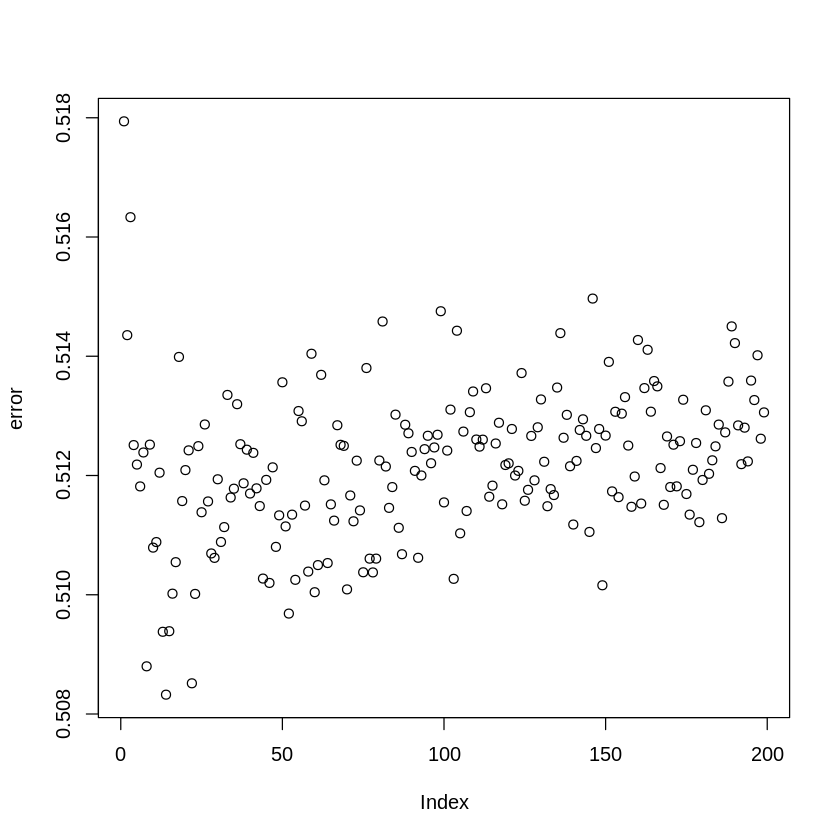

In [40]:
error <- c()
for (i in 2:200){
  k_mean_results <- apply_kmean_on_matrix(learn_matrix_norm, i)
  centers <- as.data.frame(k_mean_results["centers"])
  
  prediction <- get_prediction_by_distance(centers, valid_matrix_norm)
  prediction <- subset(prediction, select = -c(user_name, clusters))
  
  error <- c(error, evaluate(prediction, valid_matrix))
}
plot(error)

On peut en déduire que le nombre optimal de clusters est environ 25 à 30.